# Region of Interest (ROI) Extraction from ORIGA dataset images

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
base_dir = '../data/ORIGA/Images'
files = os.listdir(base_dir)
file = os.path.join(base_dir, files[0])
bgr_img = cv.imread(file)
rgb_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2RGB)
grey_img = cv.cvtColor(bgr_img, cv.COLOR_BGR2GRAY)

## Method 1: Intensity weighted centroid

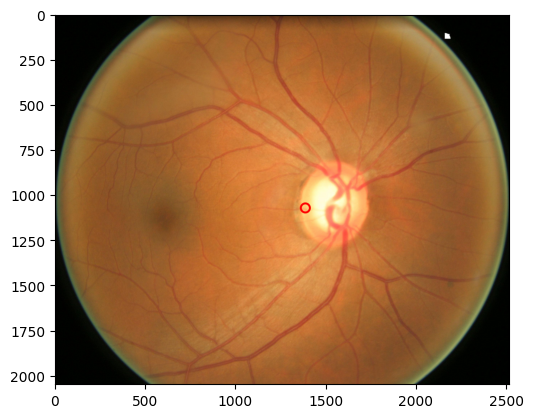

In [3]:
def intensity_weighted_centroid(image, quantile: float = None):
    weights = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    # Equalize histogram to increase contrast
    weights = cv.equalizeHist(weights)

    # Contrast Limited Adaptive Histogram Equalization (CLAHE)
    # clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    # weights = clahe.apply(weights)

    # Convert to 32-bit float and normalize
    weights = weights.astype(np.float32)
    weights -= weights.min()
    weights = weights / weights.max()

    # Apply Gaussian blur to smooth out the image
    # k_size = 65
    # weights = cv.GaussianBlur(weights, (k_size, k_size), 0)

    # Square the weights to increase the contrast
    weights = weights ** 2
    weights = weights / weights.sum()

    # Cut off the bottom % of the weights
    if quantile is not None:
        weights[weights < np.quantile(weights, quantile)] = 0

    # Find the centroid
    x = np.arange(0, weights.shape[1])
    y = np.arange(0, weights.shape[0])
    x, y = np.meshgrid(x, y)
    x_weighted = x * weights
    y_weighted = y * weights
    x_mean = np.sum(x_weighted) / np.sum(weights)
    y_mean = np.sum(y_weighted) / np.sum(weights)

    # print(f'{weights.shape = }, {x.shape = }, {y.shape = }')
    # print(f'{weights.min() = }, {weights.max() = }')
    # print(f'{x_mean = }, {y_mean = }')
    # 
    # # Add line to weights indicating the centroid
    # x_weighted[:, int(x_mean)] = np.max(x_weighted)
    # y_weighted[int(y_mean), :] = np.max(y_weighted)
    # 
    # _, ax = plt.subplots(2, 3, figsize=(15, 8))
    # ax = ax.ravel()
    # ax[0].imshow(x)
    # ax[1].imshow(y)
    # ax[2].imshow(weights)
    # ax[3].imshow(x_weighted)
    # ax[4].imshow(y_weighted)
    # ax[5].imshow(img)
    # plt.show()

    return x_mean, y_mean


img = rgb_img.copy()
center = intensity_weighted_centroid(img, 0.9)
res = cv.circle(img, (int(center[0]), int(center[1])), 25, (255, 0, 0), 10)
plt.imshow(res)
plt.show()

## Method 2: Brightest spot algorithm

max_val = 0.9777779, max_idx = array([ 997., 1511.])
cx = 1511.0, cy = 997.0


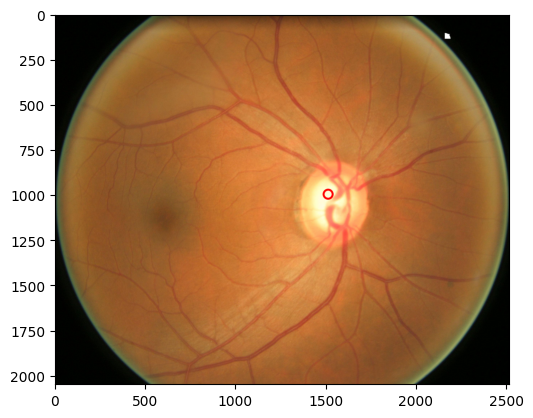

In [4]:
def brightest_spot(image, k_size: int = 65):
    grey = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    grey = grey.astype(np.float32)
    grey = grey / 255

    # Apply Gaussian blur to smooth out the image
    blurred_img = cv.GaussianBlur(grey, (k_size, k_size), 0)

    # Find the brightest spot
    max_val = np.max(blurred_img)
    max_idx = np.where(blurred_img == max_val)

    # Average the brightest spots in case there are multiple
    max_idx = np.mean(max_idx, axis=1)

    # Find the centroid of the brightest spot
    cx = np.mean(max_idx[1])
    cy = np.mean(max_idx[0])

    print(f'{max_val = }, {max_idx = }')
    print(f'{cx = }, {cy = }')

    return cx, cy


img = rgb_img.copy()
center = brightest_spot(img)
res = cv.circle(img.copy(), (int(center[0]), int(center[1])), 25, (255, 0, 0), 10)
plt.imshow(res)
plt.show()

## Method 3: Cuckoo Search Algorithm

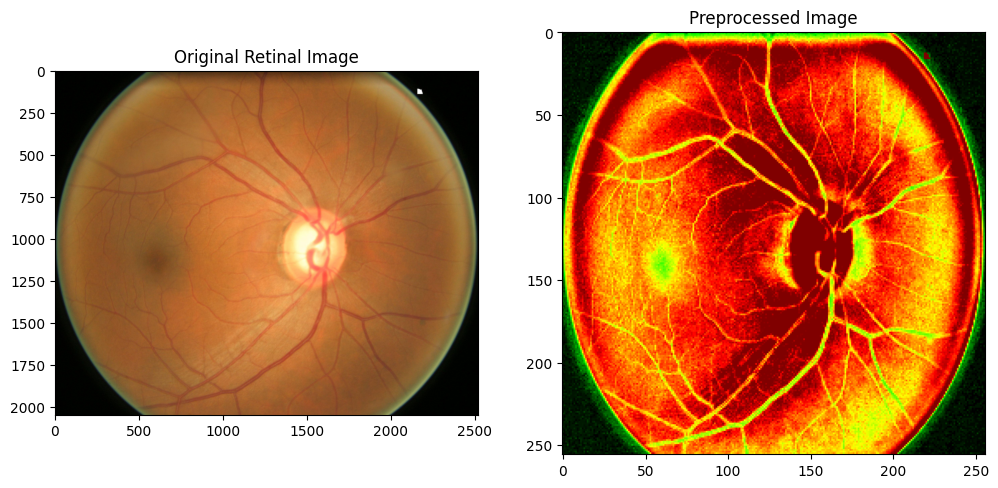

In [5]:
retinal_image = bgr_img.copy()

# Step 1: Adaptive Histogram Equalization
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(10, 10))
equalized_image = cv.cvtColor(retinal_image, cv.COLOR_BGR2GRAY)
equalized_image = clahe.apply(equalized_image)

# Step 2: Contrast Enhancement
alpha = 1.5  # adjust this value for contrast enhancement
beta = 25  # adjust this value for brightness
contrast_enhanced_image = cv.convertScaleAbs(equalized_image, alpha=alpha, beta=beta)

# Step 3: Resize to 256x256
target_size = (256, 256)
resized_image = cv.resize(contrast_enhanced_image, target_size)

# Step 4: Transform to Jet Color Map
jet_color_map = cv.applyColorMap(resized_image, cv.COLORMAP_JET)

# Step 5: Nullify the Blue Channel
jet_color_map[:, :, 0] = 0

# Display the original and preprocessed images
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(cv.cvtColor(retinal_image, cv.COLOR_BGR2RGB))
plt.title('Original Retinal Image')

plt.subplot(122)
plt.imshow(cv.cvtColor(jet_color_map, cv.COLOR_BGR2RGB))
plt.title('Preprocessed Image')
plt.show()

## Method 4: Template Matching

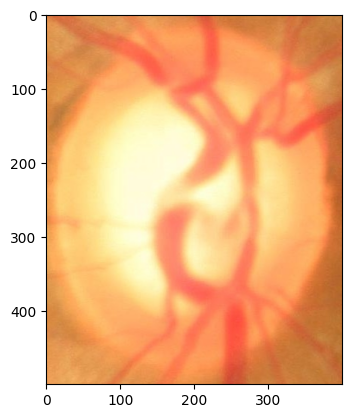

In [6]:
# Load the template
template = rgb_img.copy()[800:1300, 1350:1750, :]
plt.imshow(template)
plt.show()

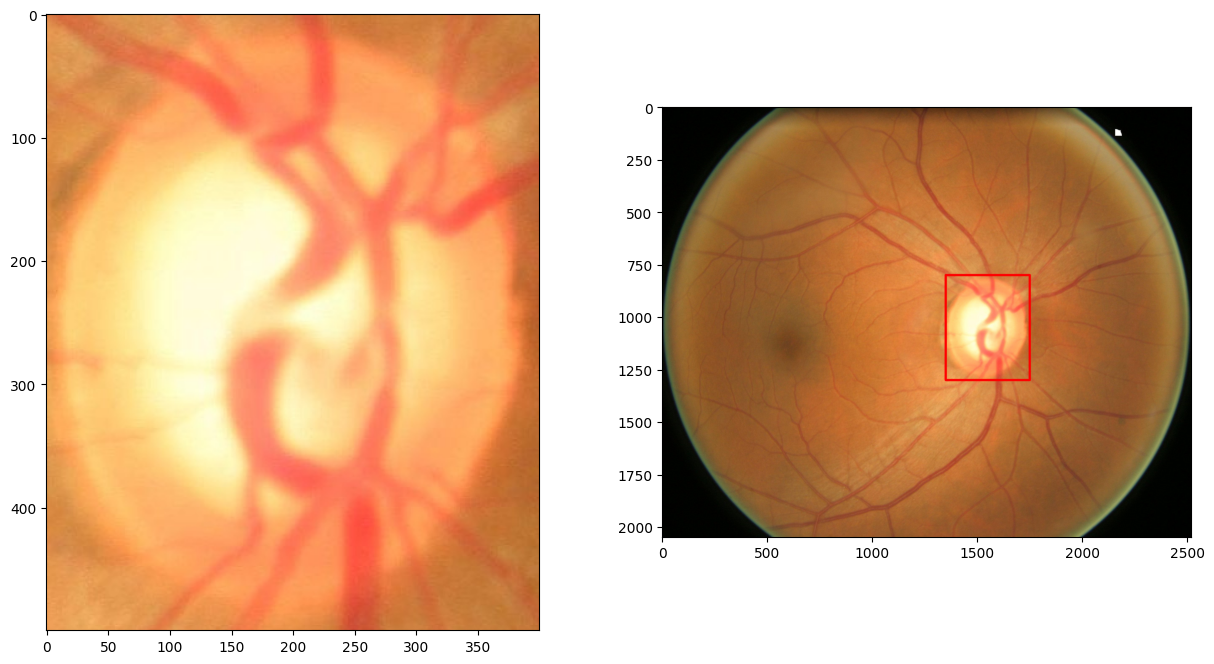

In [10]:
# Apply template Matching
res = cv.matchTemplate(img, template, cv.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)

# Draw the rectangle
top_left = max_loc
bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])
res = img.copy()
cv.rectangle(res, top_left, bottom_right, (255, 0, 0), 10)

# Plot
_, ax = plt.subplots(1, 2, figsize=(15, 8))
ax = ax.ravel()
ax[0].imshow(template)
ax[1].imshow(res)
plt.show()

## Method 5: Thresholding channel

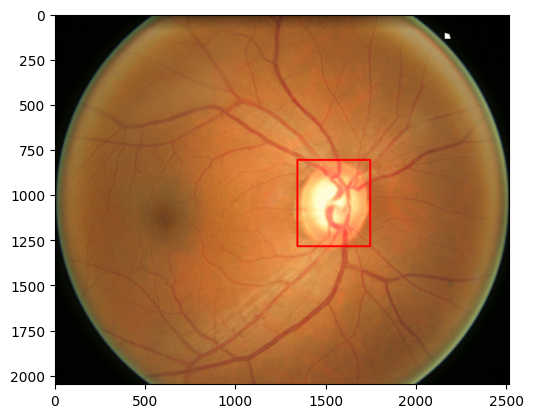

In [9]:
from utils import keep_largest_component, get_bounding_box


def threshold_channel(image, channel: int = 0, crop_size: int = 500, k_size: int = 35):
    # Crop the image to remove the black background
    image = image[crop_size: -crop_size, crop_size: -crop_size, :]

    # Get the specified channel (red, green, blue, or grey)
    channel = cv.cvtColor(image, cv.COLOR_RGB2GRAY) if channel == -1 else image[..., channel]

    # Otsu thresholding
    _, channel = cv.threshold(channel, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)

    # Dilate the mask
    kernel = cv.getStructuringElement(cv.MORPH_RECT, (k_size, k_size))
    channel = cv.dilate(channel, kernel)

    # Get bounding box of largest connected component
    channel = keep_largest_component(channel)
    x, y, w, h = get_bounding_box(channel)
    x += crop_size
    y += crop_size
    return x, y, w, h


img = rgb_img.copy()
x, y, w, h = threshold_channel(img, channel=2, crop_size=500, k_size=35)
res = cv.rectangle(img.copy(), (x, y), (x + w, y + h), (255, 0, 0), 10)
plt.imshow(res)
plt.show()


# Comparing methods